# XGBoost modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline

/opt/conda/lib/python3.4/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### This is the provided train and test split. For cross validation we can either rely on automatic folds, or if the data is ordered or we expect correlated samples (ex. repeated samples from individuals) we need to do an explicit split across time, people, etc. 

In [145]:

train = pd.read_csv("Train.csv")
test = pd.read_csv("test.csv")

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### If we use a seperated cleaning process ala. real's from the first case study.

In [4]:
# Using cleaned data
#test_cleaned = pd.read_csv('test_clean.csv')
train_cleaned = pd.read_csv('train_clean.csv')
#test_cleaned.drop('Unnamed: 0', axis=1, inplace=True)
#train_cleaned.drop('Unnamed: 0', axis=1, inplace=True)

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (14,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 55 columns):
Unnamed: 0                  401125 non-null int64
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          40

### Real's function to explore the data

In [ ]:
def print_val_counts(df):         
    ''' Will print the target variables as well'''
    for col in df.columns:
        if isinstance(df[col][0], np.int64):
            print(df[col].mean(), df[col].std())
        elif isinstance(df[col][0], np.float64):
            print(df[col].mean(), df[col].std())
        else:
            print(df[col].value_counts())

## Factorizing cleaned data

#### For practical purposes, if we have too many levels to dummify and we do not have time to do a cluster or embedding process, we can at least factorize and try it

In [254]:
test_cleaned_copy = test_cleaned.copy()
for col in test_cleaned.columns:
    col_type = test_cleaned[col][0].__class__.__name__
    if col_type == "str":
        test_cleaned_copy[col] = pd.factorize(test_cleaned_copy[col])[0]

In [319]:
train_cleaned_copy = train_cleaned.copy()
for col in train_cleaned.columns:
    col_type = train_cleaned[col][0].__class__.__name__
    if col_type == "str":
        train_cleaned_copy[col] = pd.factorize(train_cleaned_copy[col])[0]

### Starting naive model on the integer or float data. (Just to get model building pipeline in place)

In [95]:
train.select_dtypes(include=['int64','float64'], exclude=None)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
0,1139246,66000,999089,3157,121,3,2004,68
1,1139248,57000,117657,77,121,3,1996,4640
2,1139249,10000,434808,7009,121,3,2001,2838
3,1139251,38500,1026470,332,121,3,2001,3486
4,1139253,11000,1057373,17311,121,3,2007,722
5,1139255,26500,1001274,4605,121,3,2004,508
6,1139256,21000,772701,1937,121,3,1993,11540
7,1139261,27000,902002,3539,121,3,2001,4883
8,1139272,21500,1036251,36003,121,3,2008,302
9,1139275,65000,1016474,3883,121,3,1000,20700


### Setting up the xgboost data matrices

In [376]:
# Drop obvious sources of overfitting like IDs. Unless IDs have some piece of useful information embedded
# (if so, featureize them and cross validate)


train_X_df = train.drop(['SalePrice','SalesID','MachineID'],axis=1)
train_X_df = train_X_df.select_dtypes(include=['int64','float64'], exclude=None)
train_X = train_X_df.as_matrix()

train_y_df = train['SalePrice']
train_y = train_y_df.as_matrix()
train_log_y = np.log(train_y+1)

test_X_df = test.drop(['SalesID','MachineID'],axis=1)
test_X_df = test_X_df.select_dtypes(include=['int64','float64'], exclude=None)
test_X = test_X_df.as_matrix()

dtest = xgb.DMatrix(test_X)

dtrain_log = xgb.DMatrix( train_X, label=train_log_y)
included_columns = train_X_df.select_dtypes(include=['int64','float64'], exclude=None).columns

In [362]:
# BAAAAD OVERFITTING

train_X_df = train_cleaned_copy.fillna(0)
train_X_df = train_X_df.drop(['SalePrice','SalesID','MachineID','ModelID'], axis=1)
train_X_df = train_X_df.select_dtypes(include=['int64','float64','float'], exclude=None)#.ix[:,0:50]
train_X = train_X_df.as_matrix()

train_y_df = train['SalePrice']
train_y = train_y_df.as_matrix()
train_log_y = np.log(train_y+1)

test_X_df = test_cleaned_copy.fillna(0)
test_X_df = test_X_df.drop(['SalesID','MachineID','ModelID'], axis=1)
test_X_df = test_X_df.select_dtypes(include=['int64','float64','float'], exclude=None)#.ix[:,0:50]
test_X = test_X_df.as_matrix()



dtest = xgb.DMatrix(test_X)

dtrain_log = xgb.DMatrix( train_X, label=train_log_y)
included_columns = train_X_df.columns

### params

In [377]:
params = {
        'booster':"gbtree", 
        'objective':"reg:linear", 
        'max.depth':6, 
        'eta' :0.5, 
        'nthread' : 4, 
        'nround' : 1000
    }

### cross validation to find the nround range (lets not wait for a huge # of boosting rounds when iterating if not needed)

In [365]:
#train_cv_1 = xgb.cv(params, dtrain, params['nround'])
train_cv_2 = xgb.cv(params, dtrain_log, params['nround'])

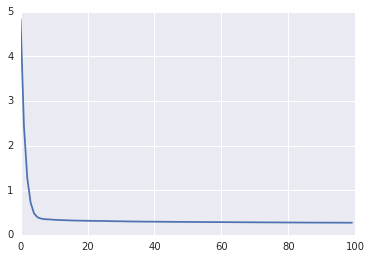

In [366]:
plt.plot(train_cv_2['test-rmse-mean'][:150])

In [368]:
print(train_cv_2['test-rmse-mean'][:5].min(),
train_cv_2['test-rmse-mean'][:10].min(),
train_cv_2['test-rmse-mean'][:20].min(),
train_cv_2['test-rmse-mean'][:30].min(),
train_cv_2['test-rmse-mean'][:40].min())

0.481481333333 0.342862 0.315233666667 0.30351 0.294074666667


### Training the model to explore feature importances etc

In [378]:
train_fitted = xgb.train(params, dtrain_log, 1000)

In [379]:
included_columns

Index(['ModelID', 'datasource', 'auctioneerID', 'YearMade',
       'MachineHoursCurrentMeter'],
      dtype='object')

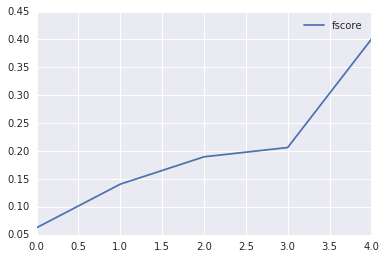

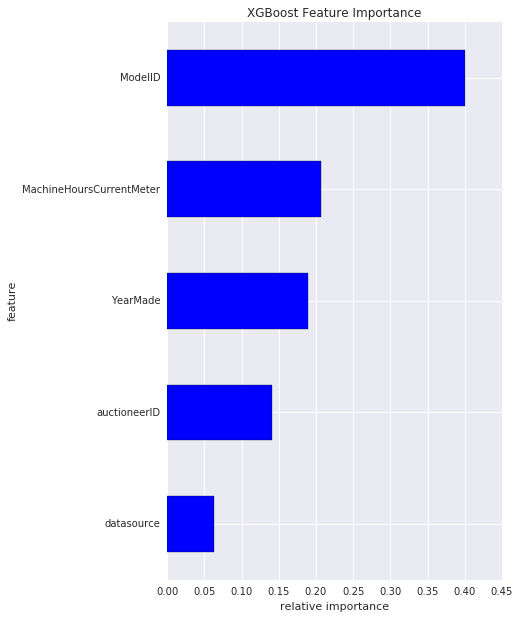

In [380]:
import operator

def feature_importances(fitted_model, included_columns):

    importance = fitted_model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['feature'] = included_columns[df['feature'].astype('str').str.replace('f','').astype(int)]
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    plt.figure()
    df.plot()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png')
    plt.show()    

## Pickling, loading models to save for future comparison.

## Cycle to try out other predictors

In [30]:
import pickle
import copy

def predictor_carousel(base_params, 
                       train_X,
                       train_y,
                       base_features, 
                       extra_features, 
                       stopping='default',
                       cv_data=False):
    '''
    Starting with a base set of features, search through the extra features which ones work well and which cause
    problems. 
    
    INPUTS:
        base_params [DICT]: The parameters for XGBoost we start with.
        train_X [Pandas DataFrame]: Training data with all features available (not the response)
        train_Y [Pandas Series]: Training response.
        base_features [LIST of STR]: Basic set of features that has passable performance. A starting point.
        extra_features [LIST of STR]: Set of features to test.
        stopping [STR]: Criteria for stopping. Can be:
            - 'default' use xgboost's early_stopping_rounds.
            - 'threshold' for finding when the speed of improvement has slowed enough to guess performance.
        cv_data [False or CV training DataFrame]: If false we do cv xgboost method. 
            - Otherwise we use this as the explicit validation set and test our performance against this.
    
    OUTPUTS:
        Ranked list of features with their score shift from base, trajectory and stopping point. 
        Repeated Pickles of the output so we can interrupt and still gain information.
    '''

    

    
    params = copy.deepcopy(base_params)
    params['early_stopping_rounds'] = 5
    params['nround'] = 100
    params['num_round'] = 100
    params['nrounds'] = 100
    
    
    results = {}
    
    for feat in extra_features:
        
        Dtrain = xgb.DMatrix( train_X[base_features + [feat]].as_matrix(), 
                              label=np.log(train_y.as_matrix())+1)
    
    
        train_cv = xgb.cv(params, Dtrain,  num_boost_round=50, nfold=5)
        
        results[feat] = train_cv
    
        pickle.dump(results, open('cv_results.pkl','wb'))
        
    return results

In [31]:
y = train_cleaned['SalePrice']


base_features = ['SalesID',                                 
'ModelID', 
'datasource',  
'auctioneerID', 
'MachineHoursCurrentMeter']

extra_features = ['Stick_Length','MachineID', 'YearMade']
                 
params = {
        'booster':"gbtree", 
        'objective':"reg:linear", 
        'max.depth':6, 
        'eta' :0.5, 
        'nthread' : 4, 
        'nround' : 1000
    }
     
predictor_carousel(params, 
                       train_cleaned.drop('SalePrice', axis=1),
                       y,
                       base_features, 
                       extra_features)

{'MachineID':     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
 0         5.334048       0.001534         5.333968        0.000200
 1         2.703795       0.001442         2.703591        0.000517
 2         1.417669       0.001280         1.417597        0.001288
 3         0.822017       0.001461         0.821845        0.001378
 4         0.579601       0.001955         0.579202        0.001613
 5         0.496488       0.003539         0.495886        0.003244
 6         0.465818       0.003332         0.465080        0.002197
 7         0.452898       0.004226         0.451992        0.002955
 8         0.444195       0.003496         0.443079        0.002361
 9         0.437315       0.003036         0.436089        0.002386
 10        0.433297       0.003131         0.431872        0.002404
 11        0.428800       0.003293         0.427454        0.002185
 12        0.425766       0.004174         0.424305        0.003136
 13        0.422528       0.004825 

# Submission File

In [381]:
sub = [[a,b] for a, b in zip(test_cleaned_copy.SalesID, np.exp(train_fitted.predict(dtest))[:])]

In [382]:
submission = pd.DataFrame(sub)

In [383]:
submission

,0,1
0,1222837,46283.656250
1,1222839,55202.375000
2,1222841,31762.576172
3,1222843,18312.306641
4,1222845,38574.679688
5,1222847,11618.715820
6,1222849,28672.638672
7,1222850,21934.128906
8,1222855,50577.910156
9,1222863,38777.285156


In [384]:
submission.rename(columns={0:'SalesID', 1:'SalePrice'}).to_csv('test_submission.csv', index=False)
